# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer, StandardScaler

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
features = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of rows and columns, print the first few rows).

#Demographics dataset 
print('Number of columns', azdias.shape[1])
print('Number of rows:', azdias.shape[0])

#Features dataset
print('Number of columns', features.shape[1])
print('Number of rows:', features.shape[0])

Number of columns 85
Number of rows: 891221
Number of columns 4
Number of rows: 85


In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
features.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Identify missing or unknown data values and convert them to NaNs.

In [7]:
# 1 - Check if there are missig values 
null_azdias = azdias.columns[azdias.isnull().any()]
azdias[null_azdias].isnull().sum()

CJT_GESAMTTYP            4854
GFK_URLAUBERTYP          4854
LP_LEBENSPHASE_FEIN      4854
LP_LEBENSPHASE_GROB      4854
LP_FAMILIE_FEIN          4854
LP_FAMILIE_GROB          4854
LP_STATUS_FEIN           4854
LP_STATUS_GROB           4854
RETOURTYP_BK_S           4854
SOHO_KZ                 73499
TITEL_KZ                73499
ALTER_HH                73499
ANZ_PERSONEN            73499
ANZ_TITEL               73499
HH_EINKOMMEN_SCORE      18348
KK_KUNDENTYP           584612
W_KEIT_KIND_HH         107602
WOHNDAUER_2008          73499
ANZ_HAUSHALTE_AKTIV     93148
ANZ_HH_TITEL            97008
GEBAEUDETYP             93148
KONSUMNAEHE             73969
MIN_GEBAEUDEJAHR        93148
OST_WEST_KZ             93148
WOHNLAGE                93148
CAMEO_DEUG_2015         98979
CAMEO_DEU_2015          98979
CAMEO_INTL_2015         98979
KBA05_ANTG1            133324
KBA05_ANTG2            133324
KBA05_ANTG3            133324
KBA05_ANTG4            133324
KBA05_BAUMAX           133324
KBA05_GBZ 

> Let's take a look at the column missing_or_unknown from the features dataset to check the different types of encoding for missing values

In [8]:
features.missing_or_unknown.value_counts()

[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[-1,X]       1
[-1,0,9]     1
[-1,XX]      1
[XX]         1
Name: missing_or_unknown, dtype: int64

In [9]:
#Create a copy of features dataframe before transformation
features_raw = features.copy()

> After trying several methods (including the creation of several columns to store the values of the missing_or_unknown list and to use a dictionary of the said values to replace the matches by NaN), I chose a very simple, efficient and time-savingless solution

In [10]:
#Change index of features dataset
features.set_index('attribute', inplace=True)

In [11]:
#Function to convert rows of features dataset in integer whenever possible
def convert_int(value): 
    try:
        return int(value)
    except:
        return value

In [12]:
#Create a dataframe before the replacement to be able to use the data later on
azdias_raw = azdias.copy()

In [13]:
#Number of missing values in the original dataset
raw_missing_values = azdias_raw.isnull().sum()
raw_missing_values.sum()

4896838

In [14]:
#Convert matching missing values - after parsing missing_or_unknown column - between azdias and features in NaNs.
for col_name in azdias.columns:
    values_to_replace = features.loc[col_name]['missing_or_unknown'].strip('][').split(',')
    azdias[col_name] = azdias[col_name].replace([convert_int(x) for x in values_to_replace], np.nan)

In [15]:
#Create a copy of the dataframe after replacement
clean_missing_values = azdias.copy()

In [16]:
#Number of missing values after transformation
replacement = clean_missing_values.isnull().sum()
replacement.sum()

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [17]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_azdias_count = azdias.isnull().sum()
missing_azdias = np.round(missing_azdias_count[missing_azdias_count > 0] / len(azdias) * 100,2)
missing_azdias.sort_values(inplace=True, ascending=True)

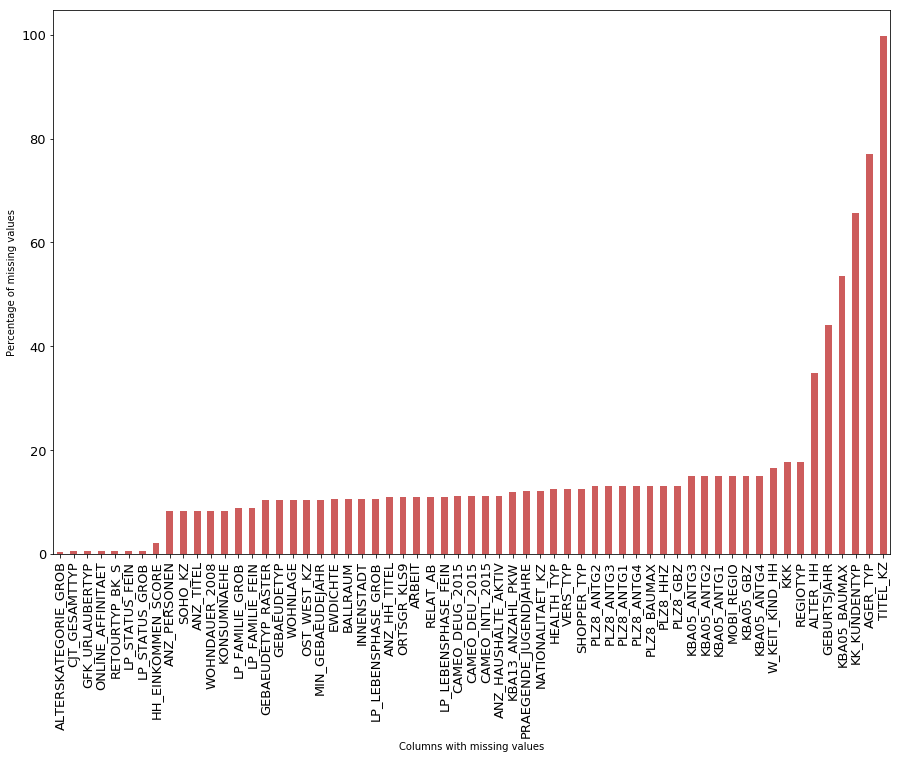

In [18]:
missing_azdias.plot.bar(figsize=(15,10),fontsize=13,color="indianred")
plt.xlabel('Columns with missing values')
plt.ylabel('Percentage of missing values')
plt.show();

In [19]:
#Summary of missing data
missing_azdias.describe()

count    61.000000
mean     15.403115
std      17.628423
min       0.320000
25%      10.450000
50%      11.150000
75%      13.070000
max      99.760000
dtype: float64

> On average, the columns contain more than 15% missing values. Let's take a look at the columns whose missing values rate is higher

In [20]:
missing_azdias[missing_azdias > 20]

ALTER_HH        34.81
GEBURTSJAHR     44.02
KBA05_BAUMAX    53.47
KK_KUNDENTYP    65.60
AGER_TYP        76.96
TITEL_KZ        99.76
dtype: float64

> By inspecting the variables with the most missing values - with the help of the data dictionary - it is clear that most of the information concerns categorical variables representing more or less sensitive personal data (age, date of birth of the head of the family, recent consumption behaviour). It is easy to understand why these attributes were not transmitted and/or anonymized for the purposes of the exercise. 

In [21]:
#Detail of the missing values added before and after 

In [22]:
#Number of missing values added after the transformation 
(replacement - raw_missing_values).sum()

3477091

In [23]:
#Compute the number of missing values before and after converting to NaNs

In [24]:
missing_before = azdias_raw.isnull().sum()
missing_before = np.round(missing_before[missing_before > 0] / len(azdias_raw) * 100,2)
missing_before.sort_values(inplace=True, ascending=True)

In [25]:
missing_after = clean_missing_values.isnull().sum()
missing_after = np.round(missing_after[missing_after > 0] / len(clean_missing_values) * 100,2)
missing_after.sort_values(inplace=True, ascending=True)

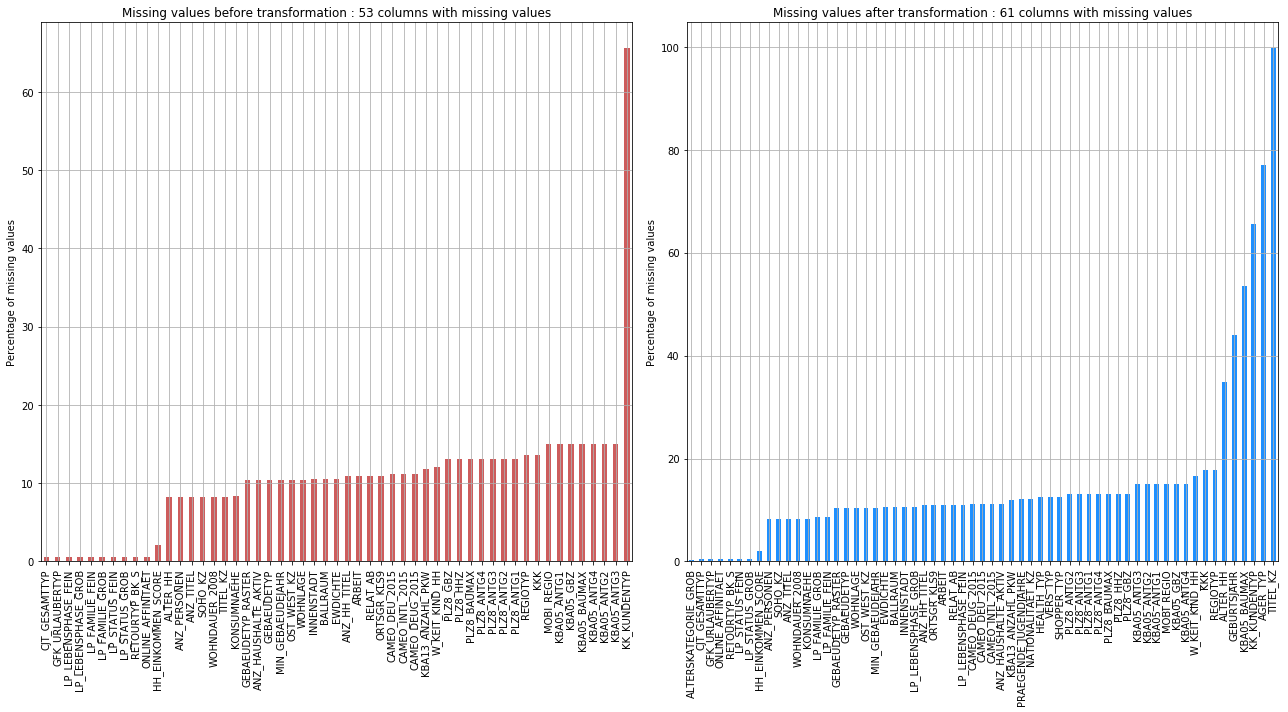

In [26]:
plt.subplot(1, 2, 1)
missing_before.plot.bar(x='attribute', y='percent_missing', figsize=(18,10), grid=True, color="indianred")
plt.title(f'Missing values before transformation : {len(missing_before)} columns with missing values')
plt.ylabel('Percentage of missing values')

plt.subplot(1, 2, 2)
missing_after.plot.bar(x='attribute', y='percent_missing', grid=True, color="dodgerblue")
plt.title(f'Missing values after transformation : {len(missing_after)} columns with missing values')
plt.ylabel('Percentage of missing values')
plt.tight_layout()
plt.show();

In [27]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

In [28]:
missing_azdias_count.describe()

count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

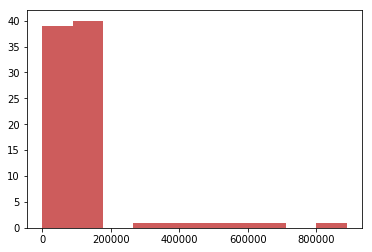

In [29]:
missing_azdias_count.hist(grid=False, color = 'indianred');

In [30]:
missing_azdias_count[missing_azdias_count > 200000] 

AGER_TYP        685843
GEBURTSJAHR     392318
TITEL_KZ        889061
ALTER_HH        310267
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
dtype: int64

> Looking at the statistics, we can see that only one column concentrates 889,061 missing values, about 99% of the total of the original dataset. However, the histogram of the number of missing values shows that the majority of the columns contain less than 200,000 missing values. It is this number that will serve as a threshold to eliminate outliers. Not surprisingly, the six columns - out of 85 - mentioned above are the ones with the most missing values and will therefore be eliminated. 

In [31]:
#Remove selected columns
azdias_filtered = azdias.drop(['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX'],axis=1)

In [32]:
azdias_filtered.shape

(891221, 79)

In [33]:
#Number of missing values after removing outliers
missing_without_outliers_count = azdias_filtered.isnull().sum()
missing_without_outliers_count.sum()

5035304

In [34]:
missing_without_outliers = np.round(missing_without_outliers_count[missing_without_outliers_count > 0] 
                                    / len(azdias_filtered) * 100,2)
missing_without_outliers.sort_values(inplace=True, ascending=True)

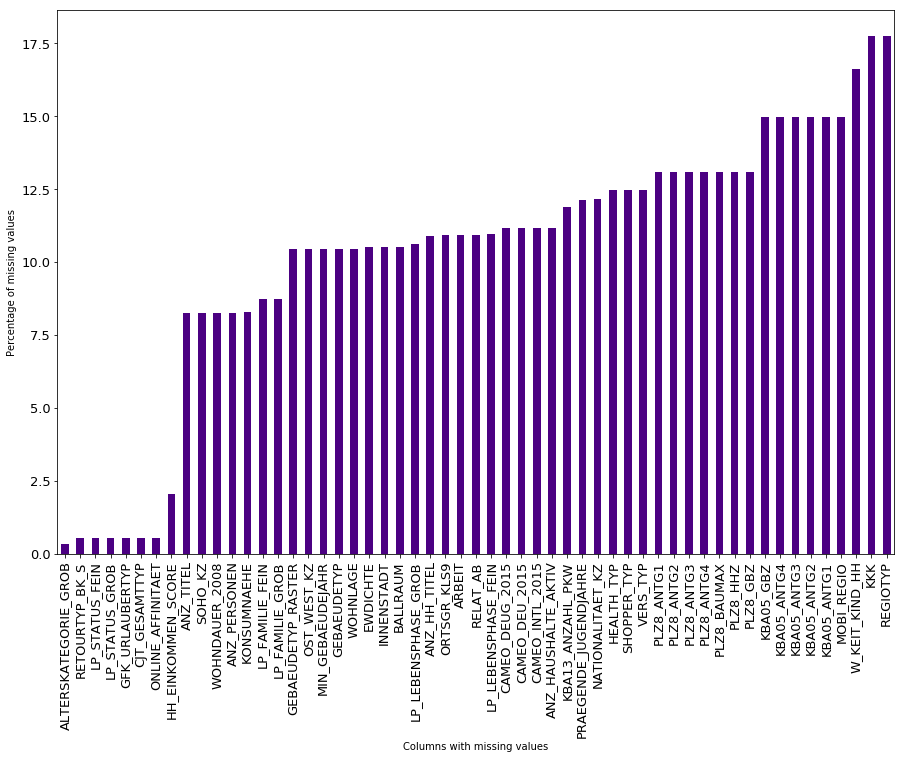

In [35]:
missing_without_outliers.plot.bar(figsize=(15,10),fontsize=13,color="indigo")
plt.xlabel('Columns with missing values')
plt.ylabel('Percentage of missing values')
plt.show();

In [36]:
# Investigate patterns in the amount of missing data in each column

> Of the 79 columns previously selected, only 55 columns contains outliers. Some groups stand out because they contain the same number of missing values (see the details below)

In [37]:
#Converting to dataframe
without_outliers_df = pd.DataFrame({'columns':missing_without_outliers_count.index, 
                                    'count':missing_without_outliers_count.values})

In [38]:
#Grouping columns by number of missing values
without_outliers_agg = [x for _, x in without_outliers_df.groupby(['count'])]
without_outliers_agg

[                  columns  count
 1               ANREDE_KZ      0
 3       FINANZ_MINIMALIST      0
 4           FINANZ_SPARER      0
 5        FINANZ_VORSORGER      0
 6          FINANZ_ANLEGER      0
 7   FINANZ_UNAUFFAELLIGER      0
 8        FINANZ_HAUSBAUER      0
 9               FINANZTYP      0
 11       GREEN_AVANTGARDE      0
 22              SEMIO_SOZ      0
 23              SEMIO_FAM      0
 24              SEMIO_REL      0
 25              SEMIO_MAT      0
 26             SEMIO_VERT      0
 27             SEMIO_LUST      0
 28              SEMIO_ERL      0
 29             SEMIO_KULT      0
 30              SEMIO_RAT      0
 31             SEMIO_KRIT      0
 32              SEMIO_DOM      0
 33             SEMIO_KAEM      0
 34          SEMIO_PFLICHT      0
 35            SEMIO_TRADV      0
 39               ZABEOTYP      0,                 columns  count
 0  ALTERSKATEGORIE_GROB   2881,               columns  count
 2       CJT_GESAMTTYP   4854
 10    GFK_URLAUBERTYP   4

In [39]:
col_group_missing_values = np.unique(without_outliers_df[ 'count'])

In [40]:
print(f'{len(col_group_missing_values)} columns with the same number of missing values')

25 columns with the same number of missing values


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [41]:
# How much data is missing in each row of the dataset?
missing_rows_values = azdias_filtered.isnull().sum(axis=1)
missing_rows_values

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

In [42]:
#Missing rows summary
missing_rows_values.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

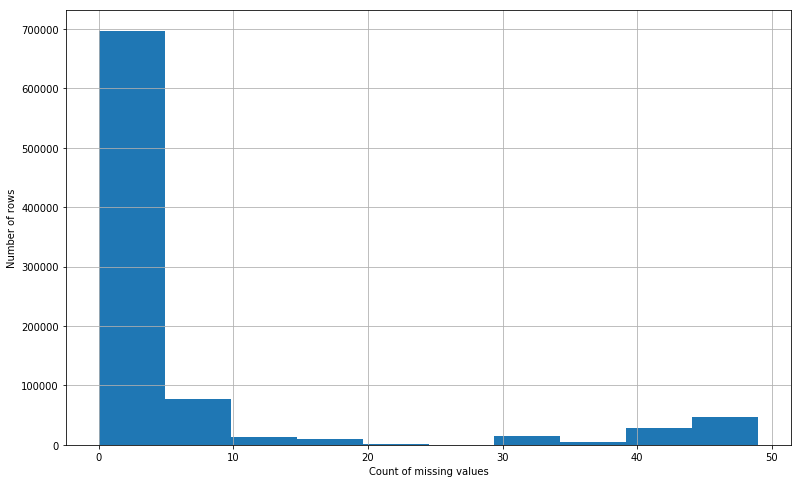

In [43]:
#Plot the summary
plt.figure(figsize=(13,8))
missing_rows_values.hist()
plt.xlabel('Count of missing values')
plt.ylabel('Number of rows')
plt.show();

In [44]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row (30 is the chosen threshold)
missing_values_high = missing_rows_values[missing_rows_values >=30]
missing_values_low = missing_rows_values[missing_rows_values < 30]

In [45]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

In [46]:
#Function to compare distribution for subsets with few and several missing values
def compare_plots(column):
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('Low missing values')
    sns.countplot(azdias_filtered.loc[missing_values_low.index,column])

    ax2 = fig.add_subplot(122)
    ax2.title.set_text('High missing values')
    sns.countplot(azdias_filtered.loc[azdias_filtered.index.isin(missing_values_high.index),column]);

    fig.suptitle(column)
    plt.show()

In [47]:
#Create a list containing the columns to compare
col_names = ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'GFK_URLAUBERTYP', 'REGIOTYP', 'KKK']

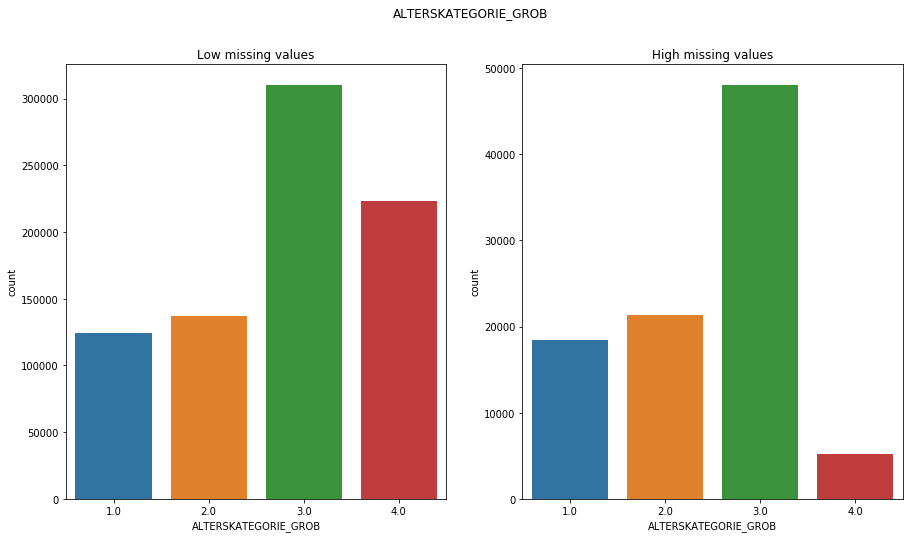

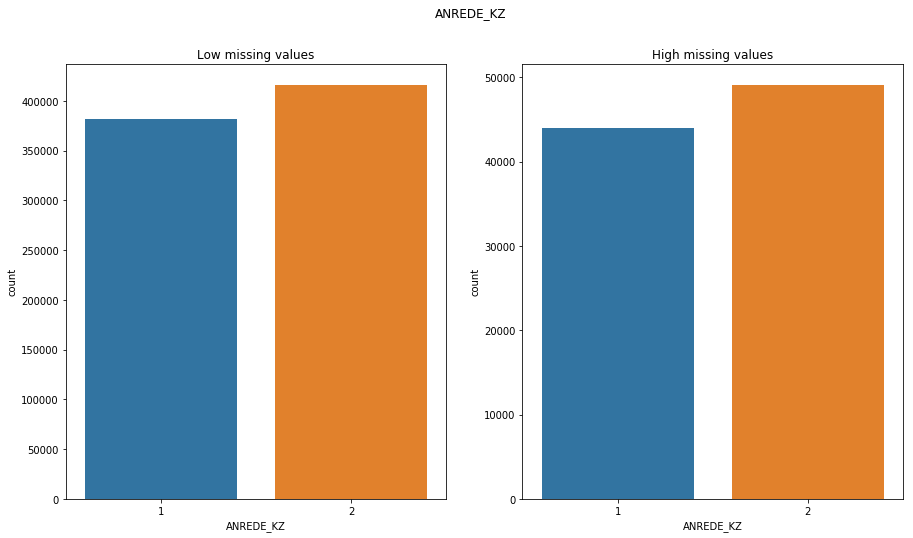

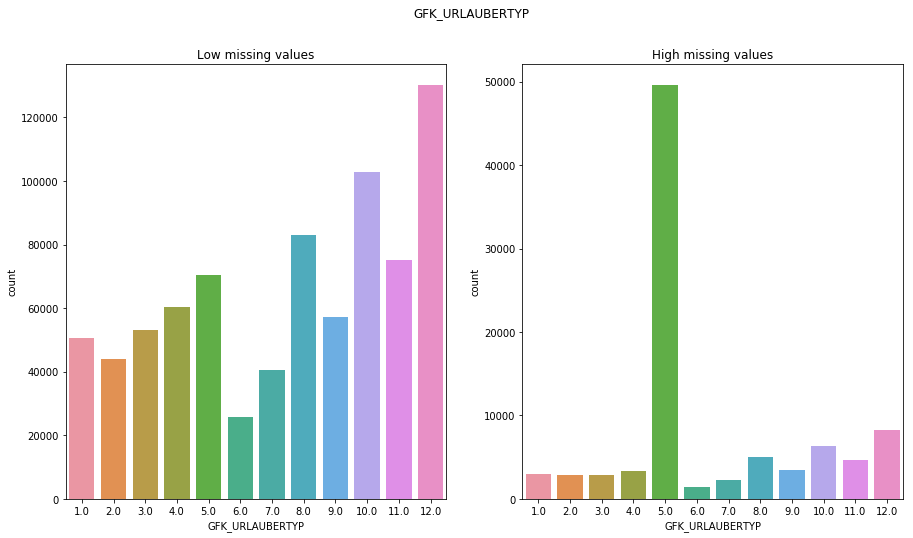

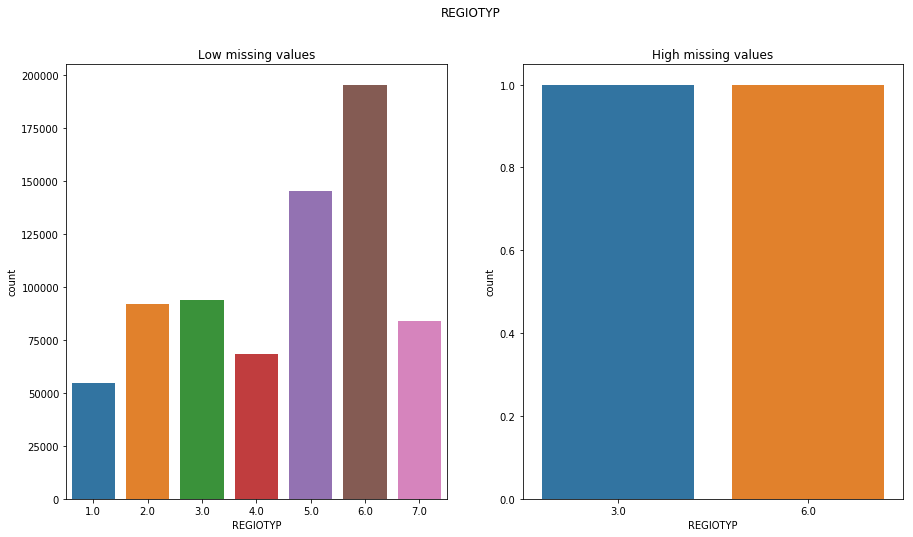

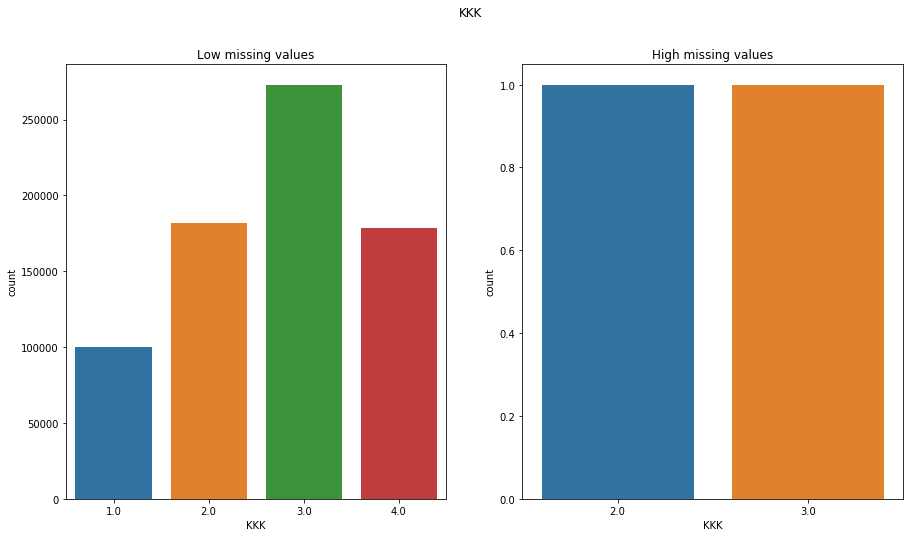

In [48]:
for col in col_names:
    compare_plots(col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

> After removing the columns containing the most outliers, I became interested in the distribution of features with a lot of missing values ( more than 30) and those with none or few (less than 30). Although the majority of distributions are equivalent from one dataset to another, there are clear differences for three columns in particular, namely GFK_URLAUBERTYP, REGIOTYP and KKK.These variables correspond to socio-demographic data, namely the social class among the neighbourhood, the purchasing power of the individual at that of the average household at the local level and personal travel habits. Very discriminating information which, if isolated, can lead to biases in the way the data are analysed. That is why I think we should keep these variables and think about a way to manage the missing data without distorting the datatset.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [49]:
# How many features are there of each data type?
features_raw['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [50]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_var = features_raw[features_raw['type'] == 'categorical']['attribute'].values

In [51]:
#We only keep the columns also present in our filtered dataset
cat_columns = [i for i in cat_var if i in azdias_filtered.columns]

In [52]:
binary = []
multilevel = []
for col in cat_columns:
    if azdias_filtered[col].nunique()==2:
        binary.append(col)
    else:
        multilevel.append(col)

print(f'{len(binary)} binary columns : {(binary)}')
print(f'{len(multilevel)} multilevel columns : {(multilevel)}')

5 binary columns : ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
13 multilevel columns : ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [53]:
#Analyze binary columns

In [54]:
azdias_filtered.ANREDE_KZ.value_counts()

2    465305
1    425916
Name: ANREDE_KZ, dtype: int64

In [55]:
azdias_filtered.GREEN_AVANTGARDE.value_counts()

0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64

In [56]:
azdias_filtered.SOHO_KZ.value_counts()

0.0    810834
1.0      6888
Name: SOHO_KZ, dtype: int64

In [57]:
azdias_filtered.VERS_TYP.value_counts()

2.0    398722
1.0    381303
Name: VERS_TYP, dtype: int64

In [58]:
azdias_filtered.OST_WEST_KZ.value_counts()

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64

In [59]:
# Re-encode categorical variable(s) to be kept in the analysis

In [60]:
#Encoding binary columns 
azdias_filtered['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)
azdias_filtered['VERS_TYP'].replace([2.0,1.0], [1,0], inplace=True)

In [61]:
#Analyze multilevel columns

In [62]:
for col in multilevel:
    print(col)
    print(len(azdias_filtered[col].value_counts()))

CJT_GESAMTTYP
6
FINANZTYP
6
GFK_URLAUBERTYP
12
LP_FAMILIE_FEIN
11
LP_FAMILIE_GROB
5
LP_STATUS_FEIN
10
LP_STATUS_GROB
5
NATIONALITAET_KZ
3
SHOPPER_TYP
4
ZABEOTYP
6
GEBAEUDETYP
7
CAMEO_DEUG_2015
9
CAMEO_DEU_2015
44


> Removing unnecessary columns (too many categories, information already present in other features, irrelevant feature) to simplify the work prior to the Principal Component Analysis

In [63]:
azdias_filtered.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,1.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,1.0,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,0.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,1.0,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,0.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,1.0,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,1.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,1.0,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [64]:
drop_multilevel = ['LP_STATUS_FEIN', 'CAMEO_DEU_2015', 'SHOPPER_TYP', 
                   'ZABEOTYP', 'LP_FAMILIE_FEIN', 'GEBAEUDETYP', 'FINANZTYP']

In [65]:
drop_binary = ['SOHO_KZ','OST_WEST_KZ']

In [66]:
drop_features = drop_multilevel + drop_binary

In [67]:
drop_features

['LP_STATUS_FEIN',
 'CAMEO_DEU_2015',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'LP_FAMILIE_FEIN',
 'GEBAEUDETYP',
 'FINANZTYP',
 'SOHO_KZ',
 'OST_WEST_KZ']

In [68]:
azdias_encoded = azdias_filtered.drop(drop_features,axis=1)

In [69]:
azdias_encoded.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_GROB,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,10.0,0,NaN,15.0,4.0,2.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,10.0,0,3.0,21.0,6.0,3.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,4.0,8,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,10.0,1,3.0,3.0,1.0,1.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,2.0,4,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,1.0,0,2.0,NaN,NaN,NaN,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,7.0,2,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5.0,0,3.0,32.0,10.0,5.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,1.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,3.0,6,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [70]:
azdias_encoded.shape

(891221, 70)

In [71]:
#Filter columns to keep before one hot encoding

In [72]:
cols_to_keep = []
for col in multilevel:
    if col not in drop_multilevel:
        cols_to_keep.append(col)

for col in binary:
    if col not in drop_binary:
        cols_to_keep.append(col)

In [73]:
cols_to_keep

['CJT_GESAMTTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_GROB',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'CAMEO_DEUG_2015',
 'ANREDE_KZ',
 'GREEN_AVANTGARDE',
 'VERS_TYP']

In [74]:
azdias_encoded = pd.get_dummies(azdias_encoded, columns=cols_to_keep)

In [75]:
azdias_encoded.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,ANREDE_KZ_1,ANREDE_KZ_2,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,VERS_TYP_0.0,VERS_TYP_1.0
0,2.0,3,4,3,5,5,3,NaN,15.0,4.0,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
1,1.0,1,5,2,5,4,5,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1
2,3.0,1,4,1,2,3,5,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0
3,4.0,4,2,5,2,1,2,2.0,NaN,NaN,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0
4,3.0,4,3,4,1,3,2,3.0,32.0,10.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1


In [76]:
azdias_encoded.shape

(891221, 107)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

> After separating the columns by type to analyze the number of values represented, there are significant differences between the variables, as some contain only two unique values while others have more than about 40 distinct values. However, this does not mean that this level of detail is not interesting, but it is a question of whether this level of granularity is interesting on the one hand and useful on the other hand with regard to the type of information it represents. 
>> I therefore chose to exclude some variables for two reasons, namely :
- a too large number of categories and irrelevant in relation to the information conveyed 
- duplicates with existing columns, keeping large scale for socio-economic characteristics

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [77]:
#Analyze mixed type columns
mix_var = features_raw[features_raw['type'] == 'mixed']['attribute'].values
mix_columns = [i for i in mix_var if i in azdias_filtered.columns]
print(mix_columns)

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


In [78]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_encoded['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    188697
8.0     145988
5.0      86416
10.0     85808
3.0      55195
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21282
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [79]:
#Engineer generation and movement variables based on PRAEGENDE_JUGENDJAHRE

In [80]:
#Create dictionaries for new values
generation_dict = {1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
movement_dict = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}

In [81]:
#Map values from dict to dataframe
azdias_encoded['JUGENDJAHRE_DECADE'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].map(generation_dict)
azdias_encoded['JUGENDJAHRE_MOVEMENT'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)

In [82]:
azdias_encoded.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,ANREDE_KZ_1,ANREDE_KZ_2,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,VERS_TYP_0.0,VERS_TYP_1.0,JUGENDJAHRE_DECADE,JUGENDJAHRE_MOVEMENT
0,2.0,3,4,3,5,5,3,NaN,15.0,4.0,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,NaN,NaN
1,1.0,1,5,2,5,4,5,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,6.0,0.0
2,3.0,1,4,1,2,3,5,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,6.0,1.0
3,4.0,4,2,5,2,1,2,2.0,NaN,NaN,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,4.0,0.0
4,3.0,4,3,4,1,3,2,3.0,32.0,10.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,4.0,0.0


In [83]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables
azdias_encoded[['CAMEO_INTL_2015']].head(10)

,CAMEO_INTL_2015
0,NaN
1,51
2,24
3,12
4,43
5,54
6,22
7,14
8,13
9,15


In [84]:
azdias_encoded['CAMEO_INTL_2015'].value_counts()

51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [85]:
#Create dictionaries for new values
wealth_dict = {'11':1,'12':1,'13':1,'14':1,'15':1,
               '21':2,'22':2,'23':2,'24':2,'25':2,
               '31':3,'32':3,'33':3,'34':3,'35':3,
               '41':4,'42':4,'43':4,'44':4,'45':4,
               '51':5,'52':5,'53':5,'54':5,'55':5}

lifestage_dict = {'11':1,'12':2,'13':3,'14':4,'15':5,
                  '21':1,'22':2,'23':3,'24':4,'25':5,
                  '31':1,'32':2,'33':3,'34':4,'35':5,
                  '41':1,'42':2,'43':3,'44':4,'45':5,
                  '51':1,'52':2,'53':3,'54':4,'55':5}          

In [86]:
#Map values from dict to dataframe
azdias_encoded['CAMEO_WEALTH'] = azdias_encoded['CAMEO_INTL_2015'].map(wealth_dict)
azdias_encoded['CAMEO_LIFESTAGE'] = azdias_encoded['CAMEO_INTL_2015'].map(lifestage_dict)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

> The purpose of this transformation is to separate the informations contained in the columns 
PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 to end up with an information by variable : 
- generation and movement for PRAEGENDE_JUGENDJAHRE 
- wealth and life stage for the column CAMEO_INTL_2015

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [87]:
#Filter WOHNLAGE to create rural and quality of neighborhood new features
azdias_encoded['RURAL_NEIGHBORHOOD'] = azdias_encoded['WOHNLAGE'].map({0:0,1:0,2:0,3:0,4:0,5:0,7:1,8:1})
azdias_encoded['NEIGHBORHOOD_RANK'] = azdias_encoded['WOHNLAGE'].map({0:0,1:1,2:2,3:3,4:4,5:5,7:0,8:0})

In [88]:
azdias_encoded.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,ANREDE_KZ_1,ANREDE_KZ_2,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,VERS_TYP_0.0,VERS_TYP_1.0,JUGENDJAHRE_DECADE,JUGENDJAHRE_MOVEMENT,CAMEO_WEALTH,CAMEO_LIFESTAGE,RURAL_NEIGHBORHOOD,NEIGHBORHOOD_RANK
0,2.0,3,4,3,5,5,3,NaN,15.0,4.0,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1,5,2,5,4,5,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,6.0,0.0,5.0,1.0,0.0,4.0
2,3.0,1,4,1,2,3,5,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,6.0,1.0,2.0,4.0,0.0,2.0
3,4.0,4,2,5,2,1,2,2.0,NaN,NaN,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,4.0,0.0,1.0,2.0,1.0,0.0
4,3.0,4,3,4,1,3,2,3.0,32.0,10.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,4.0,0.0,4.0,3.0,0.0,3.0


In [89]:
cols_to_drop = ['PRAEGENDE_JUGENDJAHRE',
                'LP_LEBENSPHASE_FEIN',
                'CAMEO_INTL_2015',
                'WOHNLAGE',
                'PLZ8_BAUMAX']

In [90]:
#Drop unuseful columns
azdias_final = azdias_encoded.drop(cols_to_drop,axis=1)

In [91]:
azdias_final.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,ANREDE_KZ_1,ANREDE_KZ_2,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,VERS_TYP_0.0,VERS_TYP_1.0,JUGENDJAHRE_DECADE,JUGENDJAHRE_MOVEMENT,CAMEO_WEALTH,CAMEO_LIFESTAGE,RURAL_NEIGHBORHOOD,NEIGHBORHOOD_RANK
0,2.0,3,4,3,5,5,3,NaN,4.0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1,5,2,5,4,5,3.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,6.0,0.0,5.0,1.0,0.0,4.0
2,3.0,1,4,1,2,3,5,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,6.0,1.0,2.0,4.0,0.0,2.0
3,4.0,4,2,5,2,1,2,2.0,NaN,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,4.0,0.0,1.0,2.0,1.0,0.0
4,3.0,4,3,4,1,3,2,3.0,10.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,4.0,0.0,4.0,3.0,0.0,3.0


In [92]:
azdias_final.shape

(891221, 108)

In [93]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

**# Step 1** 
> Same operation for the WOHNLAGE column that is filtered to create two new variables: 
- the quality of life in a neighbourhood 
- whether or not this neighbourhood is urban or rural on the other hand 

**# Step 2** 
> We remove the variables that are useless to our analysis, such as :
- the variables from which variables (news columns) have been created previously (PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015, WOHNLAGE)
- variables whose information is contained in other columns (LP_LEBENSPHASE_FEIN, PLZ8_BAUMAX)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [94]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    #Loading data
    features_raw = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
    
    #Create a copy of features dataset to apply future transformations
    features = features_raw.copy()
    features.set_index('attribute', inplace=True)
    
    #Convert missing values to NaNs 
    def convert_int(value): 
        try:
            return int(value)
        except:
            return value

    for col_name in df.columns:
        values_to_replace = features.loc[col_name]['missing_or_unknown'].strip('][').split(',')
        df[col_name] = df[col_name].replace([convert_int(x) for x in values_to_replace], np.nan)
    
    #Assess missing data for rows and columns and removing outliers 
    missing_df_count = df.isnull().sum()
    missing_df = np.round(missing_df_count[missing_df_count > 0] / len(df) * 100,2).sort_values(ascending=True)
    df_filtered = df.drop(['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX'], axis=1)
    missing_rows_df = df_filtered.isnull().sum(axis=1)
    
    #Re-encode, engineer and select columns
    cat_var = features_raw[features_raw['type'] == 'categorical']['attribute'].values
    cat_columns = [i for i in cat_var if i in df_filtered.columns]

    binary = []
    multilevel = []
    for col in cat_columns:
        if df_filtered[col].nunique()>2:
            multilevel.append(col)
    else:
        binary.append(col)
        
    df_filtered['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)
    df_filtered['VERS_TYP'].replace([2.0,1.0], [1,0], inplace=True)
    
    drop_multilevel = ['LP_STATUS_FEIN', 'CAMEO_DEU_2015', 
                       'SHOPPER_TYP', 'ZABEOTYP', 
                       'LP_FAMILIE_FEIN', 'GEBAEUDETYP', 'FINANZTYP']
    
    drop_binary = ['SOHO_KZ', 'OST_WEST_KZ']
    drop_features = drop_multilevel + drop_binary
    
    df_encoded = df_filtered.drop(drop_features,axis=1)
    
    cols_to_keep = ['CJT_GESAMTTYP',
                    'GFK_URLAUBERTYP',
                    'LP_FAMILIE_GROB',
                    'LP_STATUS_GROB',
                    'NATIONALITAET_KZ',
                    'CAMEO_DEUG_2015',
                    'ANREDE_KZ',
                    'GREEN_AVANTGARDE',
                    'VERS_TYP']
    
    df_encoded = pd.get_dummies(df_encoded, columns=cols_to_keep)
    
    generation_dict = {1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
    movement_dict = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
    df_encoded['JUGENDJAHRE_DECADE'] = df_encoded['PRAEGENDE_JUGENDJAHRE'].map(generation_dict)
    df_encoded['JUGENDJAHRE_MOVEMENT'] = df_encoded['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
    
    wealth_dict = {'11':1,'12':1,'13':1,'14':1,'15':1,
                   '21':2,'22':2,'23':2,'24':2,'25':2,
                   '31':3,'32':3,'33':3,'34':3,'35':3,
                   '41':4,'42':4,'43':4,'44':4,'45':4,
                   '51':5,'52':5,'53':5,'54':5,'55':5}
    
    lifestage_dict = {'11':1,'12':2,'13':3,'14':4,'15':5,
                      '21':1,'22':2,'23':3,'24':4,'25':5,
                      '31':1,'32':2,'33':3,'34':4,'35':5,
                      '41':1,'42':2,'43':3,'44':4,'45':5,
                      '51':1,'52':2,'53':3,'54':4,'55':5}
    df_encoded['CAMEO_WEALTH'] = df_encoded['CAMEO_INTL_2015'].map(wealth_dict)
    df_encoded['CAMEO_LIFESTAGE'] = df_encoded['CAMEO_INTL_2015'].map(lifestage_dict)
    
    df_encoded['RURAL_NEIGHBORHOOD'] = df_encoded['WOHNLAGE'].map({0:0,1:0,2:0,3:0,4:0,5:0,7:1,8:1})
    df_encoded['NEIGHBORHOOD_RANK'] = df_encoded['WOHNLAGE'].map({0:0,1:1,2:2,3:3,4:4,5:5,7:0,8:0})
    
    cols_to_drop = ['PRAEGENDE_JUGENDJAHRE','LP_LEBENSPHASE_FEIN',
                    'CAMEO_INTL_2015','WOHNLAGE','PLZ8_BAUMAX']
    
    df_final = df_encoded.drop(cols_to_drop,axis=1)
    
    return df_final

In [95]:
df_cleaned = clean_data(azdias)

In [96]:
#We check that the shape of the dataframe is the same between the result of the function and the dataset that has been transformed step by step
set(azdias_final.columns).symmetric_difference(df_cleaned.columns)

set()

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [97]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

In [98]:
#Assessment of missing values in the dataset
df_cleaned.isnull().sum()

ALTERSKATEGORIE_GROB       2881
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
HEALTH_TYP               111196
LP_LEBENSPHASE_GROB       94572
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KULT                    0
SEMIO_RAT                     0
SEMIO_KRIT                    0
SEMIO_DOM                     0
SEMIO_KAEM                    0
SEMIO_PFLICHT                 0
SEMIO_TRADV                   0
ANZ_PERSONEN              73499
ANZ_TITEL                 73499
HH_EINKOMMEN_SCORE        18348
W_KEIT_KIND_HH           147988
WOHNDAUER_2008            73499
ANZ_HAUSHALTE_AKTIV       99611
                          ...  
LP_FAMIL

In [99]:
#Extraction of columns with at least one missing value
columns_with_na = df_cleaned.columns[df_cleaned.isnull().any()].tolist()

In [100]:
#Checking columns' type for variables with missing values
for colname, coltype in df_cleaned.dtypes.iteritems():
    if colname in columns_with_na:
        print(colname, coltype)

ALTERSKATEGORIE_GROB float64
HEALTH_TYP float64
LP_LEBENSPHASE_GROB float64
RETOURTYP_BK_S float64
ANZ_PERSONEN float64
ANZ_TITEL float64
HH_EINKOMMEN_SCORE float64
W_KEIT_KIND_HH float64
WOHNDAUER_2008 float64
ANZ_HAUSHALTE_AKTIV float64
ANZ_HH_TITEL float64
KONSUMNAEHE float64
MIN_GEBAEUDEJAHR float64
KBA05_ANTG1 float64
KBA05_ANTG2 float64
KBA05_ANTG3 float64
KBA05_ANTG4 float64
KBA05_GBZ float64
BALLRAUM float64
EWDICHTE float64
INNENSTADT float64
GEBAEUDETYP_RASTER float64
KKK float64
MOBI_REGIO float64
ONLINE_AFFINITAET float64
REGIOTYP float64
KBA13_ANZAHL_PKW float64
PLZ8_ANTG1 float64
PLZ8_ANTG2 float64
PLZ8_ANTG3 float64
PLZ8_ANTG4 float64
PLZ8_HHZ float64
PLZ8_GBZ float64
ARBEIT float64
ORTSGR_KLS9 float64
RELAT_AB float64
JUGENDJAHRE_DECADE float64
JUGENDJAHRE_MOVEMENT float64
CAMEO_WEALTH float64
CAMEO_LIFESTAGE float64
RURAL_NEIGHBORHOOD float64
NEIGHBORHOOD_RANK float64


In [101]:
df_raw = df_cleaned.copy()

In [102]:
#Before performing any operations, the names of the dataset variables are kept apart
header_names = list(df_raw.columns.values)

In [103]:
imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
df_processed = imputer.fit_transform(df_raw)
df_processed = pd.DataFrame(df_processed)

In [104]:
df_processed.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107
0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,3.0,4.0,5.0,2.0,6.0,7.0,5.0,1.0,5.0,3.0,3.0,4.0,7.0,6.0,6.0,5.0,3.0,1.0,0.0,2.0,6.0,9.0,1.0,0.0,1.0,1992.0,0.0,0.0,0.0,0.0,3.0,6.0,6.0,5.0,4.0,3.0,1.0,1.0,6.0,1400.0,2.0,3.0,2.0,0.0,3.0,3.0,4.0,5.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,5.0,1.0,0.0,3.0
1,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,6.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,6.0,0.0,5.0,1.0,0.0,4.0
2,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,1.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,6.0,1.0,2.0,4.0,0.0,2.0
3,4.0,4.0,2.0,5.0,2.0,1.0,2.0,2.0,2.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,0.0,0.0,1.0,6.0,9.0,1.0,0.0,4.0,1997.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,3.0,4.0,1.0,6.0,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,4.0,0.0,1.0,2.0,1.0,0.0
4,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,10.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,4.0,0.0,4.0,3.0,0.0,3.0


In [105]:
# Apply feature scaling to the general population demographics data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_processed)
df_scaled = pd.DataFrame(df_scaled,columns=header_names)

In [106]:
df_scaled.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,ANREDE_KZ_1,ANREDE_KZ_2,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,VERS_TYP_0.0,VERS_TYP_1.0,JUGENDJAHRE_DECADE,JUGENDJAHRE_MOVEMENT,CAMEO_WEALTH,CAMEO_LIFESTAGE,RURAL_NEIGHBORHOOD,NEIGHBORHOOD_RANK
0,-0.751680,-0.056416,0.804890,-0.303378,1.285741,1.429871,-0.055511,0.938197,-0.175324,1.107928,-0.999639,0.901553,1.374629,0.537487,-1.455284,0.316841,-0.819565,-0.538400,0.056863,1.221756,0.742018,0.839442,0.420264,-0.387544,-0.593390,-0.057885,-1.379075,0.873364,0.536436,-0.436907,-0.118316,-1.167350,-0.359845,-0.907602,-0.872303,-0.552796,-0.434299,-0.109875,0.771572,1.056974,0.209499,0.267123,0.254254,-1.118995,-1.116346,0.712197,1.689863,-0.241920,0.200128,0.378140,-0.846764,-0.572015,-0.317206,0.758890,-0.120115,-0.049267,-0.353241,2.233739,-0.461435,-0.556886,-0.389460,-0.456895,-0.252964,-0.23516,-0.258954,-0.277611,-0.394698,-0.177219,-0.225033,-0.331084,-0.27014,2.677092,-0.313472,-0.429034,-0.957735,2.746703,-0.183987,-0.250909,-0.539258,1.280847,-0.58445,-0.219521,-0.473014,-0.390693,-1.817303,-0.281456,-0.197331,-0.205798,-0.320952,-0.328443,-0.363296,-0.25723,-0.367167,-0.309555,-0.421484,-0.371684,1.045218,-1.045218,0.494701,-0.494701,-0.864739,-0.899772,0.994991,-0.494701,1.039938,-1.095866,-0.514943,0.347042
1,-1.743339,-1.570358,1.487601,-1.059731,1.285741,0.757254,1.422415,0.938197,0.371202,-1.711653,0.541539,-0.142352,-0.119863,-0.539206,-1.455284,-1.166231,-1.372799,-0.538400,1.322441,-0.416882,1.298900,-0.240231,1.550121,1.369271,0.295412,-0.057885,1.079004,-0.822280,0.536436,0.231876,-0.118316,-1.167350,-0.359845,-0.907602,-0.872303,-0.552796,2.904396,-1.739380,0.771572,-0.662553,1.768571,-0.872772,-0.863071,-1.118995,0.200965,-0.987654,0.615985,-0.241920,0.200128,0.378140,0.546491,1.575581,0.640354,-0.263506,-0.120115,0.729399,-0.353241,-0.447680,-0.461435,-0.556886,2.567659,-0.456895,-0.252964,-0.23516,-0.258954,-0.277611,-0.394698,-0.177219,-0.225033,-0.331084,-0.27014,2.677092,-0.313472,-0.429034,-0.957735,-0.364073,5.435176,-0.250909,-0.539258,1.280847,-0.58445,-0.219521,-0.473014,-0.390693,0.550266,-0.281456,-0.197331,-0.205798,-0.320952,-0.328443,-0.363296,-0.25723,-0.367167,-0.309555,2.372570,-0.371684,-0.956738,0.956738,0.494701,-0.494701,-0.864739,1.111393,0.994991,-0.494701,1.039938,-1.095866,-0.514943,0.985057
2,0.239980,-1.570358,0.804890,-1.816084,-0.675554,0.084637,1.422415,0.938197,-0.995115,-0.301862,0.027813,-1.708208,-0.618027,-0.539206,-0.011411,-0.177517,0.840140,-0.538400,0.056863,1.221756,1.298900,1.379279,-0.709593,-0.387544,-0.593390,

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

> Since variables containing missing values are mostly categorical and that the values were processed earlier (re-encoding step), it seemed appropriate to replace the missing values by the most frequent ones for the columns concerned. Replacing these with the median or mean was not the best solution considering the real nature of the data, as decimal numbers are only a reflection of categorical variables. As suggested, I used StandardScaler to normalize the values.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [107]:
# Apply PCA to the data
pca = PCA()
pca_azdias = pca.fit_transform(df_scaled)

Cumulative variance explained with 60 components: 0.9266083646879966


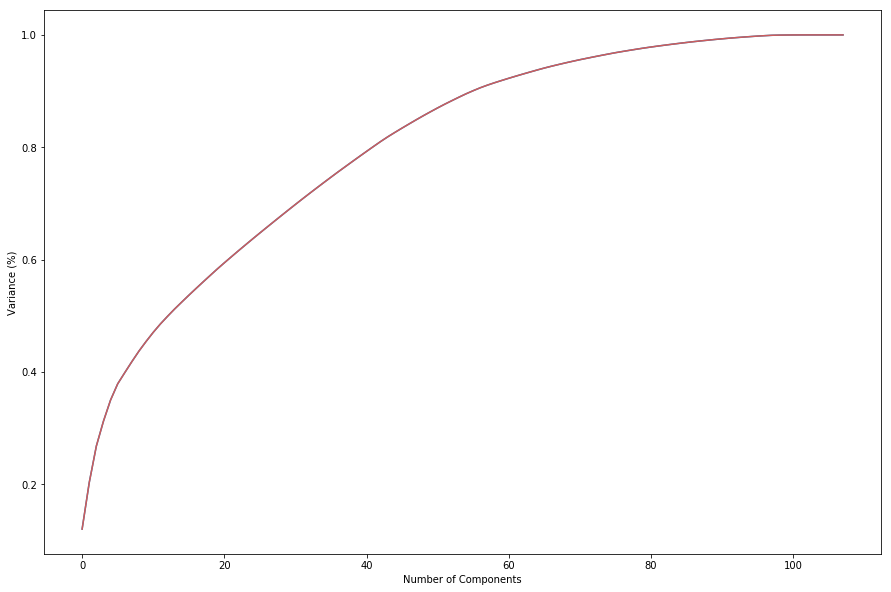

In [108]:
# Investigate the variance accounted for by each principal component
nb_of_components = len(pca.explained_variance_ratio_)
ind = np.arange(nb_of_components)
var_explained = pca.explained_variance_ratio_

plt.figure(figsize=(15,10))
cumsum_variances = np.cumsum(var_explained)
plt.plot(ind, cumsum_variances)
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='indianred')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
print('Cumulative variance explained with 60 components: {}'.format(cumsum_variances[61]))
plt.show();

In [109]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_azdias = PCA(n_components=61, random_state=42)
azdias_pca = pca_azdias.fit_transform(df_scaled)

In [110]:
pca_azdias.explained_variance_ratio_.sum()

0.92267467657032987

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

> By looking at the plot, we notice that 60 components were sufficient to explain more than 90% of the data. I could increase that value but starting with that thresold seems sufficient to me

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [111]:
def pca_analysis(dataset, pca):
    '''
    Create a dataframe to store the results of PCA
    Include dimension feature weights and explained variance
    '''

    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca_azdias.components_)+1)]

    components = pd.DataFrame(np.round(pca_azdias.components_, 4), columns = list(df_scaled.keys()))
    components.index = dimensions

    ratios = pca.explained_variance_ratio_.reshape(len(pca_azdias.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    return pd.merge(variance_ratios, components, left_index=True, right_index=True)

In [112]:
results_pca = pca_analysis(df_scaled, pca_azdias)
results_pca.head()

,Explained Variance,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,ANREDE_KZ_1,ANREDE_KZ_2,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,VERS_TYP_0.0,VERS_TYP_1.0,JUGENDJAHRE_DECADE,JUGENDJAHRE_MOVEMENT,CAMEO_WEALTH,CAMEO_LIFESTAGE,RURAL_NEIGHBORHOOD,NEIGHBORHOOD_RANK
Dimension 1,0.1200,-0.1011,-0.1978,0.1369,-0.0984,0.0828,0.0847,0.1433,0.0534,-0.1260,-0.0156,0.0022,0.0695,0.1065,0.0710,-0.0713,-0.0540,-0.0656,0.0368,0.0837,0.0420,0.0455,0.0626,0.1041,0.0616,-0.0951,-0.0070,0.1455,0.0612,-0.0435,0.1082,0.0245,-0.1562,-0.0484,-0.1984,-0.0033,0.1080,0.1233,-0.1919,-0.0852,0.1795,-0.1339,-0.0923,0.0475,-0.2061,-0.0551,0.0721,-0.0126,-0.1976,0.1386,0.2006,0.1591,0.0272,-0.1449,0.1358,0.1686,0.1169,-0.0238,-0.0539,0.0136,0.0127,0.0052,0.0412,-0.0203,-0.0193,-0.0177,0.0081,0.0079,-0.0319,-0.0449,0.0015,-0.0035,-0.0071,0.0235,0.0555,0.0723,-0.0323,0.0043,-0.0301,-0.0733,0.1860,0.0043,-0.0332,-0.1153,-0.1188,-0.0965,0.0463,0.0256,-0.0533,-0.0959,-0.0739,-0.0813,-0.0165,-0.0059,0.0282,0.0846,0.1087,-0.0203,0.0203,0.1195,-0.1195,-0.0468,-0.0019,0.1032,-0.1195,0.1982,-0.1287,-0.1386,0.1555
Dimension 2,0.0827,0.2474,0.0695,-0.2394,0.2313,-0.2237,-0.2305,0.1148,-0.0804,-0.0458,0.1623,-0.0432,-0.1650,-0.2411,-0.1576,0.0019,0.1649,0.2090,-0.1675,-0.1775,0.0486,0.0237,0.0535,-0.2265,-0.2084,-0.0558,0.0088,0.0804,0.1019,0.0412,0.0740,0.0345,-0.0395,-0.0458,-0.0405,0.0236,0.0604,0.0807,-0.0834,-0.0801,0.0648,-0.0826,-0.0526,-0.0100,-0.0398,-0.1607,-0.0116,-0.0719,-0.0845,0.0612,0.0839,0.1097,0.0309,-0.0622,0.0487,0.1003,0.0693,0.0791,0.1178,-0.0269,-0.0508,-0.0295,-0.0724,-0.0213,-0.0460,0.0360,0.0698,-0.0212,0.0197,0.0454,0.0310,-0.0716,0.0152,-0.0093,-0.0308,0.0746,0.0381,-0.0410,-0.0654,-0.0412,0.0545,-0.0450,-0.0028,-0.0270,0.0114,0.1010,-0.0398,-0.0464,0.0018,-0.0266,-0.0231,-0.0346,-0.0009,0.0224,0.0210,0.0586,0.0418,-0.0513,0.0513,-0.0057,0.0057,-0.0109,0.0582,-0.2476,0.0057,0.0463,0.0277,-0.0625,0.0624
Dimension 3,0.0651,0.0044,0.0772,-0.0411,0.0221,-0.1489,-0.0759,-0.0316,-0.0469,0.0147,0.0548,0.2765,0.2119,0.0600,0.0708,0.3214,-0.0155,-0.1721,0.2743,-0.1302,-0.2868,-0.2881,-0.3183,-0.0161,0.0179,0.0258,0.0107,0.0557,0.0017,-0.0214,0.0531,0.0186,0.0017,-0.0048,0.0046,0.0364,0.0452,0.0546,-0.0375,-0.0803,0.0168,-0.0678,-0.0514,-0.0244,0.0092,0.0047,-0.0377,-0.0947,-0.0503,0.0323,0.0448,0.0968,0.0345,-0.0355,0.0097,0.0735,0.0435,0.0171,-0.0294,0.0304,0.0412,0.0232,-0.0836,0.0079,-0.0057,0.0034,0.0284,-0.0709,0.0056,-0.0023,0.0152,-0.0085,0.0114,0.0122,0.0141,0.0314,0.0188,-0.0284,-0.0011,0.0145,0.0387,-0.0740,0.0214,-0.0055,0.0318,0.0767,

In [113]:
def plot_pca(data, pca, compo_num):
    #Vizualise best and worst values for each dimension
    compo = pd.DataFrame(np.round(pca_azdias.components_, 4), columns = data.keys()).iloc[compo_num-1]
    compo.sort_values(ascending=False, inplace=True)
    compo = pd.concat([compo.head(5), compo.tail(5)])
    fig, ax = plt.subplots(figsize = (15,10))
    compo.plot(ax = ax, kind = 'bar', title='Component' + ' ' + str(compo_num))
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show();

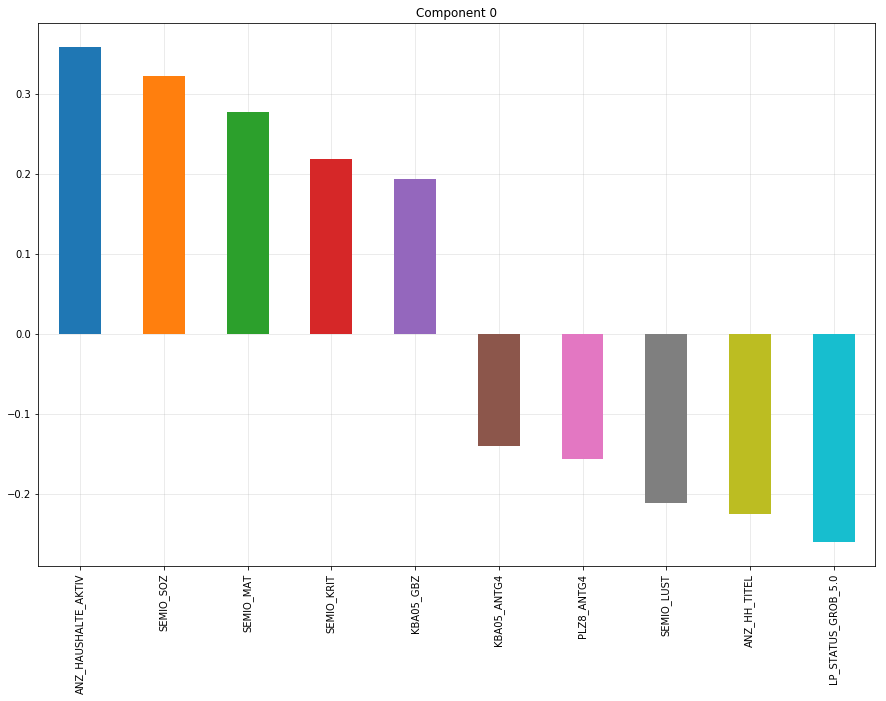

In [114]:
plot_pca(df_scaled, pca_azdias, 0)

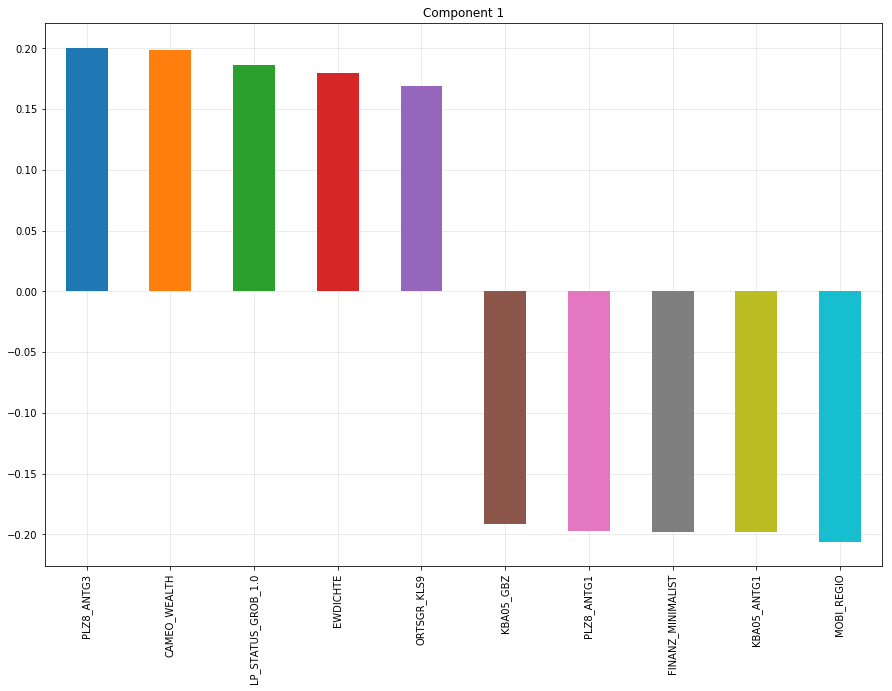

In [115]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
plot_pca(df_scaled, pca_azdias, 1)

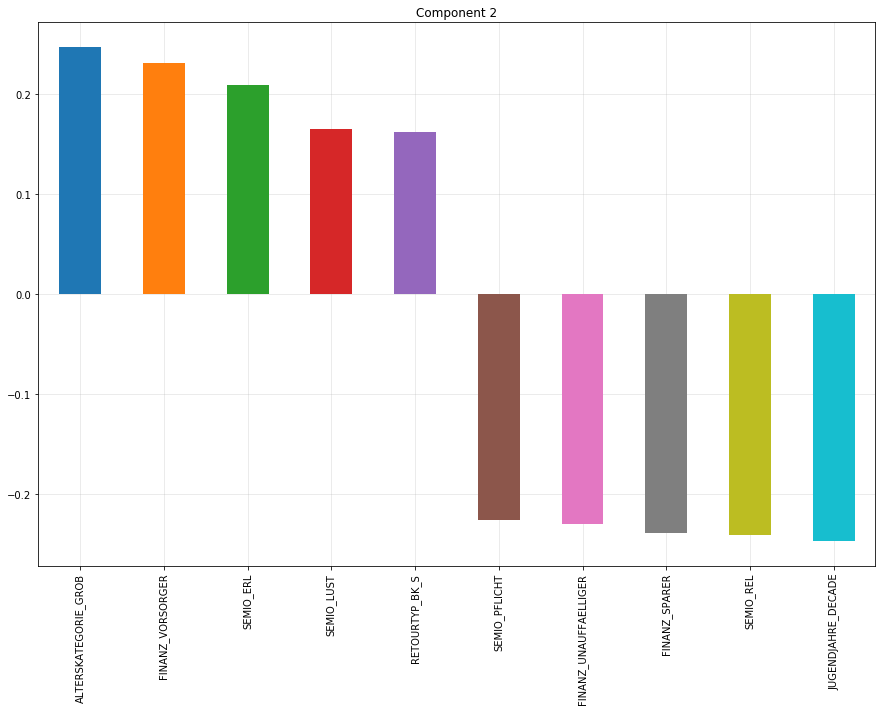

In [116]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_pca(df_scaled, pca_azdias, 2)

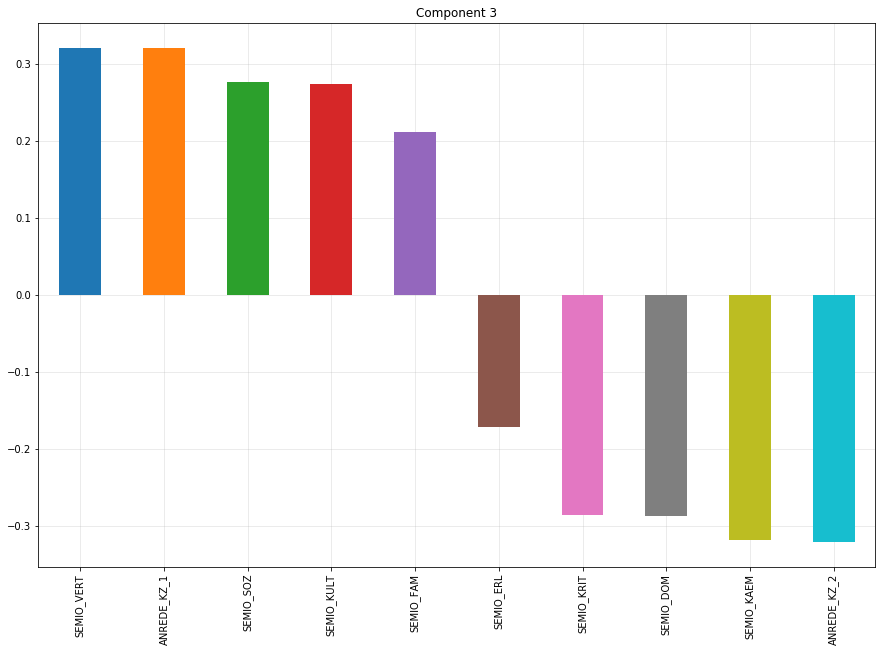

In [117]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_pca(df_scaled, pca_azdias, 3)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

Here are the results for the first four components

> **Component #0**

Positively correlated with :
- ANZ_HAUSHALTE_AKTIV : Number of households in the building
- SEMIO_SOZ : Personality typology, in this case socially-minded
- SEMIO_MAT : Personality typology, in this case materialistic
- SEMIO_KRIT : Personality typology, in this case critical-minded
- KBA05_GBZ : Number of buildings in the microcell

Negatively correlated with :
- KBA05_ANTG4 : Number of 10+ family houses in the microcell
- PLZ8_ANTG4 : Number of 10+ family houses in the PLZ8 region
- SEMIO_LUST : Personality typology, in this case sensual-minded
- ANZ_HH_TITEL : Number of professional academic title holders in building
- LP_STATUS_GROB : Social status, in this case houseowners 

*The principal component seems describe a mix of features related to economic situation of an area (wealth, density of population) and personality traits of individuals*

> **Component #1**

Positively correlated with :
- PLZ8_ANTG3 : Number of 6-10 family houses in the PLZ8 region
- CAMEO_WEALTH : Household's wealth (increasing order of poverty)
- LP_STATUS_GROB_1 : Social status, in this case low-income earneer 
- EWDICHTE : Density of households per square kilometer
- ORTSGR_KLS9 : Size of community

Negatively correlated with :
- KBA05_GBZ : Number of buildings in the microcell
- PLZ8_ANTG1 : Number of 1-2 family houses in the PLZ8 region
- FINANZ_MINIMALIST : Financial typology, in this case low financial interest
- KBA05_ANTG1 : Number of 1-2 family houses in the microcell
- MOBI_REGIO : Movement patterns

*The principal component seems describe a mix of features related to population density in a specific area and the financial condition in the area concerned*

> **Component #2**

Positively correlated with :
- ALTERSKATEGORIE_GROB : Estimated age based on given name analysis 
- FINANZ_VORSORGER : Financial typology, in this case be prepared
- SEMIO_ERL : Personality typology, in this case event-oriented
- SEMIO_LUST : Personality typology, in this case sensual-minded
- RETOURTYP_BK_S : Return type

Negatively correlated with :
- SEMIO_PFLICHT : Personality typology, in this case dutiful
- FINANZ_SPARER : Financial typology, in this case money-saver (higher means lower topology)
- FINANZ_UNAUFFAELLIGER: Financial typology, in this case inconspicuous
- SEMIO_REL : Personality typology, in this case religious
- JUGENDJAHRE_DECADE : Generation of an person according to his year of birth (in decades) 

*The principal component seems describe a mix of features related to personality traits and socio-demographic attributes of individuals*

> **Component #3**

Positively correlated with :
- SEMIO_VERT : Personality typology, in this case dreamful
- ANREDE_KZ_1 : Gender, in this case male
- SEMIO_SOZ : Personality typology, in this case socially-minded
- SEMIO_KULT : Personality typology, in this case cultural-minded
- SEMIO_FAM : Personality typology, family-minded

Negatively correlated with :
- SEMIO_ERL : Personality typology, in this case event-oriented
- SEMIO_KRIT : Personality typology, in this case critical-minded
- SEMIO_DOM : Personality typology, in this case dominant-minded
- SEMIO_KAEM : Personality typology, in this case combative attitude
- ANREDE_KZ_2 : Gender, in this case female

*The principal component seems describe a mix of features related to gender of individuals and personalities*

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [118]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances

In [119]:
#Using a sample (20% of the dataset) to reduce computation time
azdias_pca_sample = azdias_pca[np.random.choice(azdias_pca.shape[0], \
                                                int(azdias_pca.shape[0]*0.2), replace=False)]

In [120]:
scores = []
for x in list(range(2,48,2)):
    kmeans = MiniBatchKMeans(x)
    kmeans.fit(azdias_pca_sample)
    print(x,kmeans.score(azdias_pca_sample))
    scores.append(kmeans.score(azdias_pca_sample))

2 -16621985.9032
4 -14757274.8278
6 -14066145.6935
8 -13114682.717
10 -13022089.973
12 -12320265.0798
14 -12183168.6079
16 -12042757.0266
18 -11993575.2186
20 -11871896.4095
22 -11683475.5874
24 -11446900.2931
26 -11519249.2355
28 -11338999.7492
30 -11226087.2016
32 -11103023.1939
34 -10979667.8265
36 -11023039.1087
38 -10874500.911
40 -10875113.8665
42 -10763970.7824
44 -10689397.4284
46 -10604883.6178


In [121]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

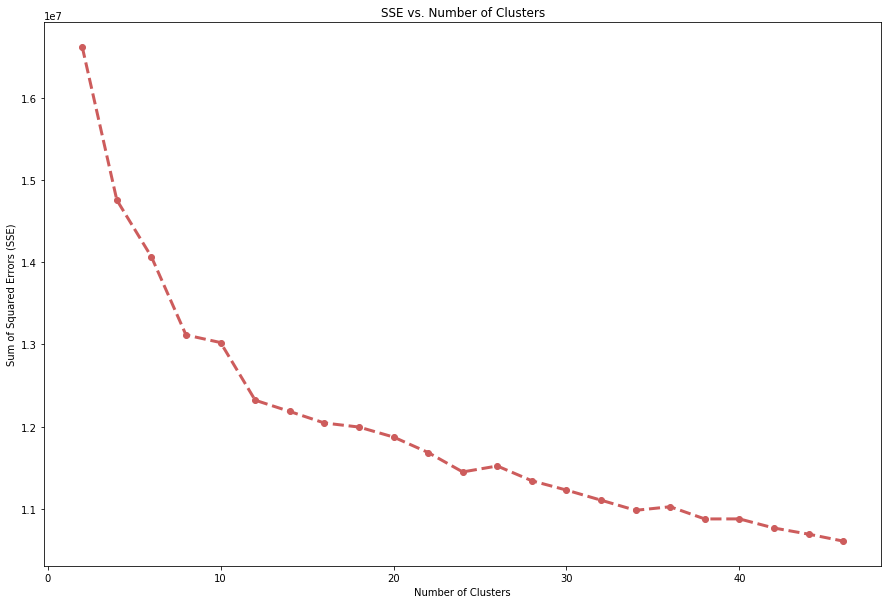

In [122]:
scores_to_plot = [abs(i) for i in scores]
x = range(2,48,2)
plt.figure(figsize=(15, 10))
plt.plot(x, scores_to_plot, linestyle='--',linewidth=3, marker='o', color='indianred')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('SSE vs. Number of Clusters')
plt.show();

In [123]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

In [124]:
start_time = time.time()

n_clusters = 24
kmeans = KMeans(n_clusters = n_clusters, random_state=42)
azdias_clusters = kmeans.fit_predict(azdias_pca);

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

--- Run time: 11.82 mins ---


> I started by setting the number of clusters at 30. I have therefore decided to reduce this threshold to 24 on the one hand, to avoid memory problems and on the other hand, because there is no significant difference beyond this threshold. 

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [125]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [126]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_cleaned = clean_data(customers)
customers_cleaned.isnull().sum()

customers_na = customers_cleaned.columns[customers_cleaned.isnull().any()].tolist()
customers_names = list(customers_cleaned.columns.values)

imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
customers_processed = imputer.fit_transform(customers_cleaned)
customers_processed = pd.DataFrame(customers_processed)

scaler = StandardScaler()
customers_scaled = scaler.fit_transform(customers_processed)
customers_scaled = pd.DataFrame(customers_scaled,columns=customers_names)

In [127]:
pca_customers = PCA(n_components=61, random_state=42)
customers_pca = pca_customers.fit_transform(customers_scaled)

In [128]:
customers_pca = pd.DataFrame(customers_pca)
customers_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,-5.459462,-3.508225,-0.786952,-1.127715,-3.368594,-1.540148,3.368854,0.995540,-1.630244,1.151239,-0.262600,-1.267257,-0.924240,1.743543,0.370766,-1.747513,-0.429462,-0.212995,0.698770,0.240511,2.006900,-1.433341,-0.154677,2.005950,1.494972,-1.630007,-0.352211,1.118174,0.381555,0.932714,0.399524,0.800166,0.236916,0.578162,-0.163824,0.495265,-0.333233,-1.250852,-1.872286,2.021469,-0.505603,1.235517,-0.199776,-0.123242,0.096618,0.644743,0.301277,-0.148714,-0.857267,-0.507296,0.435521,-1.287354,0.298671,-0.310622,0.383793,0.996831,1.350376,0.045511,-1.023497,-0.266284,1.027682
1,-0.345765,-1.541571,-0.740114,0.491648,-3.322858,1.790161,-1.129284,1.745650,0.610123,0.440071,0.615258,-0.124236,0.200148,0.070681,-0.053055,0.012052,-0.079738,0.134665,-0.513756,0.037090,0.274916,0.176077,0.004282,0.088958,-0.282505,-0.078312,-0.033170,-0.106247,-0.153909,-0.232172,-0.034105,-0.121503,0.160468,-0.151835,0.007024,0.105433,-0.132035,-0.587748,0.884600,-0.254526,-0.150733,0.099898,-0.171722,0.507503,0.064554,-0.453622,-0.082122,0.132992,0.205087,0.491693,-0.934486,-0.540826,-0.161452,0.553801,-0.130415,0.187548,1.307640,0.152270,-0.313719,-0.876261,0.552897
2,-1.698723,3.620507,1.525828,-4.776147,-0.027197,-0.969870,-0.725838,-0.338079,-0.398223,-0.821722,-0.630332,2.721356,-0.970804,-2.069744,-1.631317,-0.418727,-0.161634,0.220519,-0.915124,0.238043,-0.296789,-0.744465,1.320162,-0.271156,-0.892313,1.639957,-0.763122,-2.433082,-1.747498,-0.175049,1.276992,0.950328,-1.450238,1.177977,-0.449456,-0.470775,-0.394421,-1.979119,-0.789897,0.028502,0.653793,0.881160,-0.267027,-0.055161,-0.603401,1.019067,1.332101,0.484128,-0.420600,-0.032635,0.975388,-0.125178,-0.068837,-0.215207,-0.939322,-0.375436,0.175711,0.243202,-0.497121,1.012605,-0.384555
3,-2.178453,-3.294931,3.323610,2.785768,-3.122350,-0.240077,0.747201,-0.555802,-0.242190,-0.443938,-0.082225,0.376580,1.060622,-0.151081,0.209861,0.054466,-1.246405,-0.309592,-1.907147,-1.310015,0.712503,0.309744,-1.142062,-1.077518,0.518127,0.512924,-0.769223,-1.308877,0.068450,-0.129443,-0.433708,0.101830,-1.605130,0.409224,0.478051,0.550932,-0.708288,1.014741,0.035263,0.201564,-0.763034,-0.120135,0.454470,0.148537,0.528548,-0.109433,0.151279,0.566110,0.797840,1.227968,-0.016543,0.443968,-0.055469,-0.863260,0.538910,-1.614813,0.398585,-1.378600,0.326126,-0.289963,-0.403783
4,-0.147724,3.399466,-1.321610,5.205573,2.986318,1.825993,-0.619112,-0.471263,-1.878669,-0.006222,-0.285201,0.480216,0.787102,0.726741,-1.549514,-0.438369,1.052213,0.339213,1.015522,0.217731,-1.678001,-2.479097,-1.138515,-1.474171,0.756781,-1.977338,-1.584478,1.030307,1.158380,-2.501451,0.564385,2.567721,-0.519366,2.406527,0.565119,0.122453,1.727979,-0.221661,-0.647626,0.276667,2.143697,0.208246,0.325137,2.094442,-0.978850,1.340129,0.803341,-0.337635,2.018819,0.030811,-0.375568,-0.019361,1.233146,-0.194727,-1.288317,0.244109,-1.284063,0.701228,-0.508362,0.220486,0.023593


In [129]:
customer_clusters = kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [130]:
# Converting predicted labels to dataframes
labels_azdias = pd.DataFrame(azdias_clusters, index=range(len(azdias_clusters)), columns=['Cluster'])
labels_customers = pd.DataFrame(customer_clusters, index=range(len(customer_clusters)), columns=['Cluster'])

In [131]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

In [136]:
#source : https://github.com/tbemsi/UdacityCapstoneArvato/blob/master/notebook.ipynb

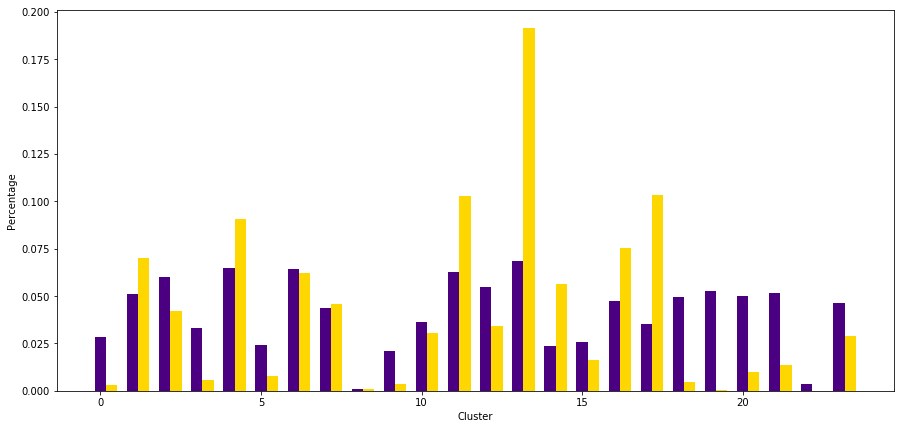

In [132]:
n_population = []
n_customer = []
for i in range(n_clusters):
    n_population.append(np.argwhere(azdias_clusters==i).shape[0]/azdias_clusters.shape[0])
    n_customer.append(np.argwhere(customer_clusters==i).shape[0]/customer_clusters.shape[0])


label_counts = pd.DataFrame({'Global Dataset': n_population})
label_counts['Customer Dataset'] = pd.Series(n_customer)
label_counts['Clusters'] = pd.Series(list(range(n_clusters)))

# Plotting bar chart to visualize these proportions
customer_props = label_counts['Customer Dataset']
general_props = label_counts['Global Dataset']

ind = np.arange(n_clusters) 
width = 0.35 

plt.figure(figsize=(15,7))
plt.bar(ind, general_props, width, color='indigo', label='General')
plt.bar(ind + width, customer_props, width, color='gold',
    label='Customer')

plt.ylabel('Percentage')
plt.xlabel('Cluster')
plt.legend(loc='best')
plt.show();

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

In [133]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

<Container object of 20 artists>

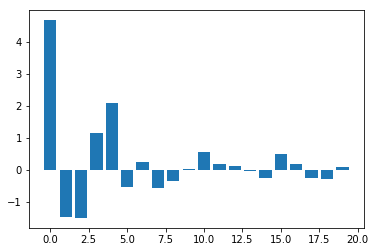

In [134]:
over_represented_cluster = azdias_clusters==13
plt.bar(np.arange(20), np.mean(azdias_pca[over_represented_cluster][:,:20], axis=0))

> We filter the data from the customer dataset corresponding to cluster 13 and then determine which main components are most represented (0,3,4) for the cluster. 
3 typical profiles stand out from the group :

- Young people (probably students) living in a residence mainly composed of studios or two rooms, open-minded, sociable and not very materialistic
- Single men, rather dreamy, sociable and interested in the arts
- Very wealthy, urban and traditionalist households, sensitive to ecology

<Container object of 20 artists>

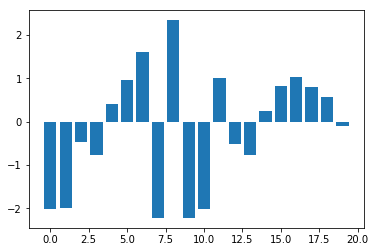

In [135]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
under_represented_cluster = azdias_clusters==5
plt.bar(np.arange(20), np.mean(azdias_pca[under_represented_cluster][:,:20], axis=0))

> Same as above, 4 typical profiles stand out from the group :
- Middle-class households, living on the suburbs and travelling mainly by car, traditional and risk averse
- Elderly people living in families, living in a chic and conservative neighbourhood, wealthy and with purchasing power in the high average
- Very wealthy, urban and traditionalist households, sensitive to ecology 
- Conservative low-income German households living close to local shops

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.